<h1><center>Une application de recommandation de contenu</center></h1>

<hr>
<h3><center>√âlaboration d‚Äôun mod√®le Content-Based Filtering</center></h3>
<br>

>__R√©alis√© par : Said Arrazouaki__


>__Encadr√© par : Addi Ait-Mlouk__

## Introduction

Le filtrage bas√© sur le contenu consiste √† recommander des articles en s‚Äôappuyant uniquement sur leurs caract√©ristiques propres, et non sur les comportements des autres utilisateurs. Concr√®tement, chaque article est d√©crit par un ¬´‚ÄØportrait num√©rique‚ÄØ¬ª sous forme de vecteur‚ÄØ: deux articles proches dans cet espace vectoriel partagent des th√®mes, des mots-cl√©s ou des rubriques similaires. Lorsqu‚Äôun utilisateur a consult√© un article, on lui propose donc d‚Äôautres contenus dont le vecteur est proche de celui qu‚Äôil vient de lire.

Dans notre cas, ces vecteurs sont issus d‚Äôun apprentissage pr√©alable qui combine le texte et les m√©tadonn√©es de chaque article. Ils √©taient initialement de dimension‚ÄØ250, mais pour all√©ger les calculs nous utilisons la version r√©duite articles_embeddings_reduced.pickle qui ne comporte plus que 75 dimensions tout en conservant l‚Äôessentiel de l‚Äôinformation (gr√¢ce √† une r√©duction de dimension type PCA conservant plus de 98‚ÄØ% de la variance). Pour comparer les articles dans cet espace, nous utiliserons la similarit√© cosinus, une mesure adapt√©e aux vecteurs de grande dimension‚ÄØ: elle vaut 1 pour deux vecteurs identiques et tend vers 0 lorsque les articles partagent peu de contenu en commun. Ainsi, pour chaque utilisateur, nous pourrons identifier et lui sugg√©rer les articles les plus proches de ceux qu‚Äôil a appr√©ci√©s.

## 1. Chargement des donn√©es

Commen√ßons par charger les diff√©rentes donn√©es n√©cessaires¬†:
- Le fichier articles_embeddings_reduced.pickle
- Le fichier articles_metadata.csv
- Les fichiers clicks/clicks_hour_*.csv

In [3]:
import pandas as pd
import numpy as np
import pickle
import glob

In [4]:
# Charger les m√©tadonn√©es des articles
articles_df = pd.read_csv('../data/articles_metadata.csv')
print("Nombre d'articles :", len(articles_df))

Nombre d'articles : 364047


In [5]:
# Charger la matrice d'embeddings des articles
with open('../data/processed/articles_embeddings_reduced.pickle', 'rb') as f:
    embeddings_matrix = pickle.load(f)
print("Taille de la matrice d'embeddings :", embeddings_matrix.shape)

Taille de la matrice d'embeddings : (364047, 75)


In [6]:
embeddings_matrix.head()

0         1         2         3         4         5         6   \
0 -2.176782  1.316913 -1.029048  0.901908 -1.809543 -2.064712 -1.221915   
1 -1.735174 -0.489893  3.268562  0.087855  1.473058 -0.932711  1.841632   
2 -0.912689  2.089340  1.865869 -1.202520  2.530599 -0.521971  0.224352   
3  1.096567 -0.212955  4.183517 -0.649575 -0.130866  1.126555  1.063997   
4  0.193785  0.263949  1.896583 -1.834345  1.270376 -1.723297  0.329007   

         7         8         9   ...        65        66        67        68  \
0 -0.024443  0.927260 -0.669805  ...  0.528111 -0.112972 -0.419169 -0.001754   
1 -0.881798 -0.207203  0.816809  ... -0.111876  0.144479  0.199041  0.175780   
2  1.479936 -0.191897  1.356800  ... -0.136365 -0.145220 -0.142428 -0.067773   
3 -0.662877  0.348141  1.463900  ...  0.295610 -0.351968 -0.044041  0.055246   
4  0.283796 -0.659808  1.223740  ... -0.120979 -0.379417  0.106974 -0.154591   

         69        70        71        72        73        74  
0 -0.066866 -0.288364  0.166554 -0.091761  0.154860 -0.046834  
1 -0.089538 -0.041962 -0.094137 -0.045636  0.174000 -0.216366  
2 -0.274823 -0.045927 -0.235927 -0.184537  0.233155  0.030380  
3  0.292920  0.015151 -0.322508 -0.051290 -0.103305  0.026568  
4  0.133175  0.035721  0.055303 -0.038804  0.118085  0.043850  

[5 rows x 75 columns]

In [7]:
# Charger et concat√©ner tous les fichiers de clics horaires
clicks_files = glob.glob('../data/clicks/clicks_hour_*.csv')
clicks_list = [pd.read_csv(f) for f in clicks_files]
clicks_df = pd.concat(clicks_list, ignore_index=True)
print("Nombre total de clics :", len(clicks_df))

Nombre total de clics : 2988181


In [ ]:
# lire les user_clicks
with open('../data/processed/user_clicks.pickle', 'rb') as f:
    user_clicks = pickle.load(f)

In [40]:
user_clicks

{0: [157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205],
 1: [235840,
  96663,
  59758,
  160474,
  285719,
  156723,
  205973,
  283392,
  327984,
  183176,
  36162,
  234481],
 2: [119592, 30970, 30760, 209122],
 3: [236065,
  236294,
  234686,
  233769,
  235665,
  235132,
  161178,
  236444,
  234318,
  284985,
  235689,
  236671,
  293114,
  233688,
  237452,
  235745,
  120967],
 4: [48915, 44488, 195887, 195084, 63307, 336499, 271261],
 5: [168868,
  207122,
  286413,
  156543,
  284664,
  156672,
  59929,
  60253,
  160974,
  50864,
  348132,
  284622,
  158082,
  162655,
  284901,
  61741,
  283933,
  282785,
  284664,
  286420,
  156619,
  271551,
  233717,
  158646,
  124228,
  283776,
  286310,
  237257,
  42612,
  159200,
  237356,
  272218,
  202763,
  158642,
  169169,
  286350,
  69433,
  159177,
  202632,
  161801,
  149622,
  159190,
  282917,
  348128,
  348091,
  348135,
  348113,
  348117,
  162663,
  158794,
  348128,
  62631,
  61698,
  36399,
  284090,


## Construction du profil utilisateur

Pour g√©n√©rer des recommandations bas√©es sur le contenu, nous avons besoin d‚Äôun profil utilisateur construit √† partir des articles qu‚Äôil a lus. Nous utilisons pour cela les vecteurs d‚Äôembedding associ√©s √† ces articles. Deux approches seront test√©es‚ÄØ:

1. Dernier clic‚ÄØ: on part du dernier article consult√© et on propose des articles qui lui ressemblent.

2. Historique complet‚ÄØ: on calcule un vecteur moyen √† partir de tous les articles lus (avec ou sans pond√©ration par le nombre de clics) et on recommande les contenus les plus proches de ce profil global

#### Strat√©gie¬†1 : Dernier clic

La premi√®re strat√©gie de filtrage bas√© sur le contenu consiste √† recommander des articles similaires au dernier article consult√© par l‚Äôutilisateur. L‚Äôhypoth√®se est qu‚Äô√† court terme, ce dernier article refl√®te son centre d‚Äôint√©r√™t imm√©diat‚ÄØ: on lui propose donc des lectures dans le m√™me th√®me.

In [10]:
def get_user_profile_last_click(user_id):
    """
    Calcule le vecteur de profil de l'utilisateur dans l'espace des embeddings.
    Utilise l'embedding du dernier article cliqu√© par l'utilisateur.
    """
    if user_id not in user_clicks or len(user_clicks[user_id]) == 0:
        return None
    clicked_articles = user_clicks[user_id]
    last_article_id = clicked_articles[-1]
    
    user_vector = embeddings_matrix.iloc[last_article_id].values
    return user_vector

In [11]:
# Test
example_user = list(user_clicks.keys())[0]
print("Articles consult√©s par l'utilisateur", example_user, ":", user_clicks[example_user])
print("Vecteur utilisateur (derni√®re lecture) :\n ", get_user_profile_last_click(example_user))

Articles consult√©s par l'utilisateur 0 : [157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205]
Vecteur utilisateur (derni√®re lecture) :
  [ 3.5097826   0.3197432  -2.8272414   1.2147856  -2.4664311   0.75618213
  0.39984334 -0.03059885  1.0965923   1.5024184   0.19609752 -0.6678464
 -1.8609488  -0.17532755  1.4579573   0.17034769 -0.5554228   0.04796061
  0.02243927  0.4893204   1.0710903  -0.2817194   0.1746169   0.44367397
 -0.3509412   1.6358695  -0.18399507 -0.3180685  -0.11830416 -0.47575703
 -0.6972884  -1.6537611  -0.31716073  0.34681767  0.3096094   0.22866894
  0.3064115  -0.36587805  0.37635493 -0.20751148  0.24671033 -1.4426922
  0.36083615 -0.24379197 -0.5290104  -0.47769496  0.43597186 -0.25581273
 -0.36937964  1.0034635  -0.06948723 -0.02474904  0.14468059 -0.33981743
 -0.14640924 -0.21542889  0.40753004  0.9795211   0.60704255  0.25672913
 -0.24450316 -0.16079397 -0.5961052  -0.16017714  0.25987467  0.00523037
  0.0069142  -0.21241808  0.14140403  0.18993519  0.

#### Strat√©gie¬†2 : Historique complet

La seconde strat√©gie vise √† profiler l‚Äôutilisateur en utilisant tous les articles qu‚Äôil a lus, plut√¥t que seulement le plus r√©cent. On va calculer un vecteur profil pour l‚Äôutilisateur, en faisant la moyenne (pond√©r√©e ou non) des vecteurs des articles qu‚Äôil a consult√©s.

Formellement, si $U$ est l‚Äôensemble des articles cliqu√©s par l‚Äôutilisateur (par exemple sur une p√©riode donn√©e ou l‚Äôensemble de l‚Äôhistorique), on calcule :

üîπ **Profil non pond√©r√© :**

$$
p = \frac{1}{|U|} \sum_{i \in U} v_i
$$

üîπ **Profil pond√©r√© :**

$$
p_w = \frac{1}{\sum_{i \in U} w_i} \sum_{i \in U} w_i \, v_i
$$

o√π $w_i$ est un poids associ√© √† l‚Äôarticle $i$, en fonction du nombre de clics de l‚Äôutilisateur sur cet article.  
Ici, $w_i$ peut simplement √™tre le nombre de fois que l‚Äôutilisateur a cliqu√© sur l‚Äôarticle $i$, de sorte qu‚Äôun article consult√© plusieurs fois aura plus d‚Äôinfluence dans le profil.

In [12]:
def get_user_profile_mean(user_id, weighted=False):
    clicked_articles = user_clicks.get(user_id, [])
    if not clicked_articles:
        return None


    vectors = embeddings_matrix.iloc[clicked_articles].values

    if weighted:
        # Pond√©ration par fr√©quence des clics
        article_counts = pd.Series(clicked_articles).value_counts()
        weights = np.array([article_counts[articles_df.iloc[idx]['article_id']] for idx in clicked_articles])
        user_vector = np.average(vectors, axis=0, weights=weights)
    else:
        user_vector = np.mean(vectors, axis=0)

    return user_vector


## Calcul similarit√© et recommandation

Une fois que nous avons le vecteur profil de l‚Äôutilisateur (not√© $u$), nous calculons la similarit√© cosinus entre ce vecteur et tous les vecteurs d‚Äôarticles candidats. 

La similarit√© cosinus entre deux vecteurs $x$ et $y$ est d√©finie par¬†:

$$
\text{sim}(x, y) = \frac{x \cdot y}{\|x\| \, \|y\|}
$$

Cette mesure varie de -1 √† 1, o√π : 1 signifie que les vecteurs sont colin√©aires (tr√®s similaires en orientation, donc articles tr√®s similaires), 0 signifie qu‚Äôils sont orthogonaux (aucune similarit√©), -1 signifie qu‚Äôils sont de sens oppos√©s (rare dans notre contexte).


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_articles(user_vector, user_id, top_n=5):
    if user_vector is None:
        popular_articles = clicks_df['click_article_id'].value_counts().head(top_n).index.tolist()
        return popular_articles

    similarities = cosine_similarity([user_vector], embeddings_matrix.values)[0]

    # Ignorer les articles d√©j√† vus
    seen_articles = set(user_clicks.get(user_id, []))
    for idx in seen_articles:
        if idx is not None:
            similarities[idx] = -1

    top_indices = similarities.argsort()[::-1][:top_n]
    #recommended_article_ids = articles_df.iloc[top_indices]['article_id'].tolist()
    recommendations = []
    for idx in top_indices:
        art_id = articles_df.iloc[idx]['article_id'] if 'article_id' in articles_df.columns else idx
        recommendations.append((art_id, similarities[idx]))
    return recommendations

In [14]:
def recommend_last_click(user_id, top_n=5):
    user_vector = get_user_profile_last_click(user_id)
    return recommend_articles(user_vector, user_id, top_n)

def recommend_mean_clicks(user_id, top_n=5, weighted=False):
    user_vector = get_user_profile_mean(user_id, weighted)
    return recommend_articles(user_vector, user_id, top_n)


Test des fonctions de recommandations:

In [26]:
# Un utilisateur d'exemple
example_user = list(user_clicks.keys())[0]

In [27]:
# Dernier clic
print("Recommendations pour l'utilisateur", example_user, "avec la strategie dernier clic:")
for art, sim in recommend_last_click(example_user):
    print(f"  Article {art} (similarit√© = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie dernier clic:
  Article 86143 (similarit√© = 0.877)
  Article 87427 (similarit√© = 0.876)
  Article 87676 (similarit√© = 0.873)
  Article 87278 (similarit√© = 0.872)
  Article 86613 (similarit√© = 0.871)


In [28]:
# Historique complet sans pond√©ration
print("Recommendations pour l'utilisateur", example_user, "avec la strategie historique complet sans pond√©ration:")
for art, sim in recommend_mean_clicks(example_user, weighted=False):
    print(f"  Article {art} (similarit√© = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie historique complet sans pond√©ration:
  Article 161133 (similarit√© = 0.848)
  Article 162235 (similarit√© = 0.840)
  Article 161789 (similarit√© = 0.840)
  Article 159495 (similarit√© = 0.835)
  Article 107637 (similarit√© = 0.833)


In [29]:
# Historique complet avec pond√©ration
print("Recommendations pour l'utilisateur", example_user, "avec la strategie historique complet avec pond√©ration:")
for art, sim in recommend_mean_clicks(example_user, weighted=True):
    print(f"  Article {art} (similarit√© = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie historique complet avec pond√©ration:


  Article 161133 (similarit√© = 0.848)
  Article 162235 (similarit√© = 0.840)
  Article 161789 (similarit√© = 0.840)
  Article 159495 (similarit√© = 0.835)
  Article 107637 (similarit√© = 0.833)


## visualisations

In [30]:
from sklearn.decomposition import PCA

# R√©duction de dim avec PCA
pca = PCA(n_components=2)
articles_2D = pca.fit_transform(embeddings_matrix)


# On ajoute les colonnes 2D au dataframe
articles_df['x'] = articles_2D[:, 0]
articles_df['y'] = articles_2D[:, 1]

In [31]:
def mark_articles(user_id, recommended_ids):
    clicked_ids = user_clicks.get(user_id, [])

    articles_df['status'] = 'all'
    articles_df['last_clicked'] = False

    if clicked_ids:
        articles_df.loc[articles_df['article_id'].isin(clicked_ids), 'status'] = 'clicked'
        articles_df.loc[articles_df['article_id'].isin(recommended_ids), 'status'] = 'recommended'
        last_id = clicked_ids[-1]
        articles_df.loc[articles_df['article_id'] == last_id, 'last_clicked'] = True


In [32]:
import matplotlib.pyplot as plt

def plot_user_recommendations(user_id, recommended_ids):
    mark_articles(user_id, recommended_ids)

    plt.figure(figsize=(12, 8))

    # Articles g√©n√©raux
    df_all = articles_df[articles_df['status'] == 'all']
    plt.scatter(df_all['x'], df_all['y'], c='lightgray', s=10, label='Tous les articles', alpha=0.3)

    # Articles cliqu√©s
    df_clicked = articles_df[(articles_df['status'] == 'clicked') & (~articles_df['last_clicked'])]
    plt.scatter(df_clicked['x'], df_clicked['y'], c='royalblue', s=60, label='Articles cliqu√©s')

    # Recommand√©s
    df_rec = articles_df[articles_df['status'] == 'recommended']
    plt.scatter(df_rec['x'], df_rec['y'], c='limegreen', s=80, edgecolor='black', linewidths=0.5, label='Recommandations')

    # Dernier clic (point rouge)
    df_last = articles_df[articles_df['last_clicked']]
    plt.scatter(df_last['x'], df_last['y'], c='red', s=120, edgecolor='black', linewidths=1.2, label='Dernier article cliqu√©', marker='*')

    plt.title(f"Recommandations pour l'utilisateur {user_id}", fontsize=16)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
# Un utilisateur d'exemple
example_user = list(user_clicks.keys())[0]

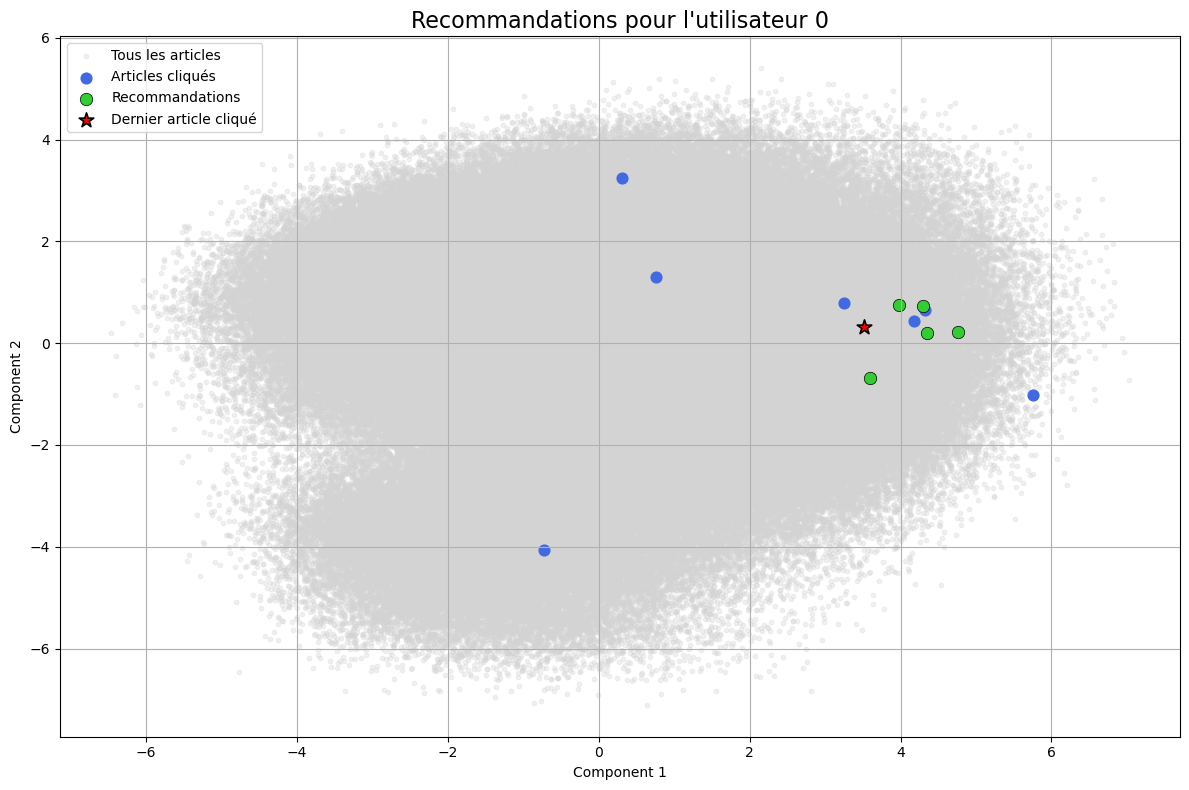

In [34]:
# Recommandations pour l'utilisateur avec la strat√©gie dernier clic
recommended_ids = []
for art in recommend_last_click(example_user):
    recommended_ids.append(art[0]) 

plot_user_recommendations(example_user, recommended_ids)

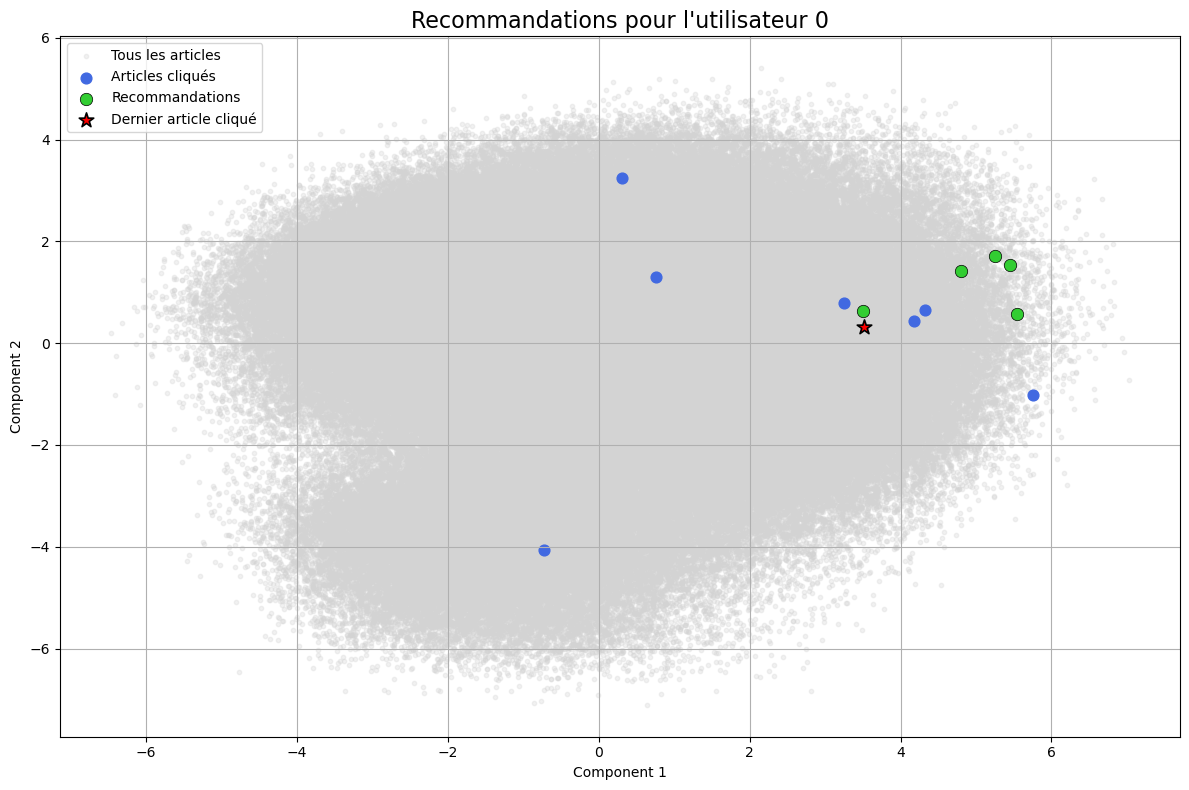

In [35]:
#Recommendations pour l'utilisateur avec la strat√©gie historique complet sans pond√©ration
recommended_ids = []
for art in recommend_mean_clicks(example_user, weighted=False):
    recommended_ids.append(art[0])
plot_user_recommendations(example_user, recommended_ids)

## Conclusion 

Dans ce premier module, nous avons donc charg√© et pr√©par√© les donn√©es, construit des profils utilisateurs √† partir des embeddings et mis en ≈ìuvre plusieurs variantes du filtrage bas√© sur le contenu. Deux fonctions de recommandation ont √©t√© d√©velopp√©es‚ÄØ:

- recommend_last_click(user_id), qui s‚Äôappuie uniquement sur le dernier article consult√© pour proposer des contenus similaires¬†;

- recommend_mean_clicks(user_id, weighted=False/True), qui calcule un vecteur moyen √† partir de l‚Äôensemble des articles lus, avec la possibilit√© de pond√©rer chaque article par sa fr√©quence de consultation.

Apr√®s √©valuation, nous retenons pour la mise en production la fonction last¬†click, qui offre un bon compromis entre pertinence et simplicit√© de calcul. Une fois les embeddings charg√©s en m√©moire, cette approche est tr√®s rapide √† ex√©cuter et facile √† int√©grer dans une Azure¬†Function‚ÄØ: il suffit de charger les fichiers n√©cessaires au d√©marrage et de renvoyer les cinq articles les plus proches en r√©ponse √† chaque requ√™te. Les autres variantes restent √† disposition pour explorer des strat√©gies plus fines ou pond√©r√©es si cela s‚Äôav√®re n√©cessaire √† l‚Äôavenir.